In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
%load_ext autoreload
%autoreload 2

---
## Read Data

In [5]:
from Data_prep import leave_last_out

In [10]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../'

In [11]:
data_path = 'Data/Amazon/'
file_name = 'am_20k_users'
# file_name = 'am_like_ml'

# data_path = 'Data/ML/'
# file_name = 'ml_1m'

In [12]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [13]:
# CFRNN Data
train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')

# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

In [14]:
# Eval
steps = 5
rank_at = 20

---
# BPR

In [42]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 40, #around 20 is sufficient
"sample_size": 0.5*len(train_set_mf),
"seed": 1234,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.55, # Bold driver decrease alpha
          
"reg_user": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
}

In [55]:
from BPR import BPR
bpr = BPR(total_users, total_items, bpr_params)

In [53]:
samples_name = file_name + '_bpr_samples'

In [45]:
samples = bpr.create_samples(train_set_mf)

Creating 40 samples of length 88904


100% |########################################################################|


In [46]:
samples = np.array(samples)
np.save(path + data_path + 'Samples/' + samples_name, samples)

In [56]:
%%time
bpr.train_model(sample_path = path + data_path + 'Samples/' + samples_name + '.npy', 
                train_set=train_set_mf, 
                val_set=val_set_mf,
                verbose=1,
                patience=10,
                save_best=True)

Training BPR on 40 samples of size 88904
iteration: 0  loss: 0.708695  val_rec@10: 0.0
no improvement
iteration: 1  loss: 0.706129  val_rec@10: 0.0
no improvement
iteration: 2  loss: 0.703855  val_rec@10: 0.0
best updated
iteration: 3  loss: 0.701784  val_rec@10: 0.002
best updated
iteration: 4  loss: 0.699508  val_rec@10: 0.005
best updated
iteration: 5  loss: 0.697177  val_rec@10: 0.009
best updated
iteration: 6  loss: 0.694253  val_rec@10: 0.012
best updated
iteration: 7  loss: 0.691154  val_rec@10: 0.014
best updated
iteration: 8  loss: 0.687299  val_rec@10: 0.02
best updated
iteration: 9  loss: 0.683171  val_rec@10: 0.022
best updated
iteration: 10  loss: 0.678914  val_rec@10: 0.03
best updated
iteration: 11  loss: 0.674397  val_rec@10: 0.033
no improvement
iteration: 12  loss: 0.669006  val_rec@10: 0.033
no improvement
iteration: 13  loss: 0.663456  val_rec@10: 0.032
best updated
iteration: 14  loss: 0.65806  val_rec@10: 0.034
best updated
iteration: 15  loss: 0.653605  val_rec@1

results added


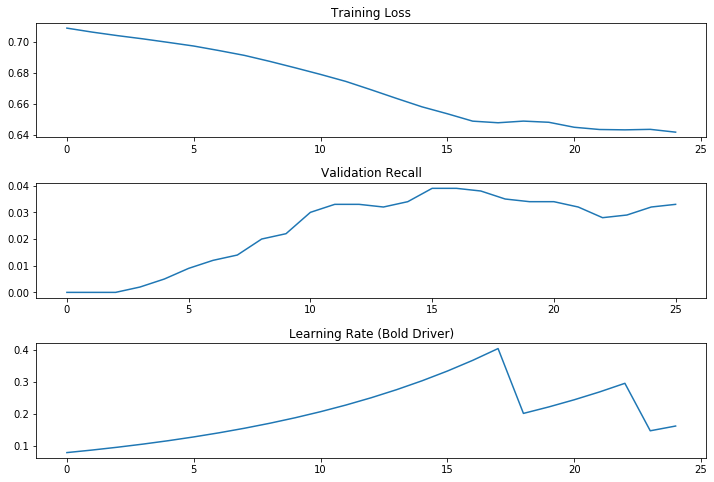

In [57]:
bpr.store_model(path + '/Logs/', file_name + '_bpr_log', file_name)
bpr.plot_training()

In [17]:
ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,12,0.012,0.01200,0.012000
1,5,66,0.066,0.01320,0.040333
2,10,81,0.081,0.00810,0.045131
3,15,87,0.087,0.00580,0.046714
4,20,87,0.087,0.00435,0.046714


In [58]:
ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,45,0.0225,0.022500,0.022500
1,5,66,0.0330,0.006600,0.027843
2,10,76,0.0380,0.003800,0.029455
3,15,77,0.0385,0.002567,0.029583
4,20,80,0.0400,0.002000,0.029932


In [18]:
bpr_metrics.to_pickle(path + 'Results/BPR/' + file_name + '_metrics')

---
# CFRNN

In [22]:
cfrnn_params = {
'train_time':0,
'epochs':100,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'test_users': 500,
'val_users': 500,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [30]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, cfrnn_params)
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set_cfrnn)

Creating Diveristy Bias
Compiled LSTM


In [31]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)

In [ ]:
cfrnn.train(train_dataset, val_dataset, verbose=1)

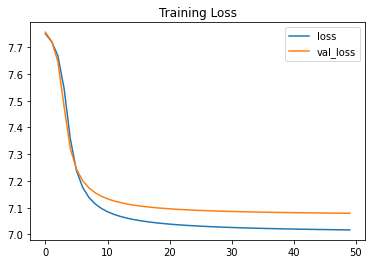

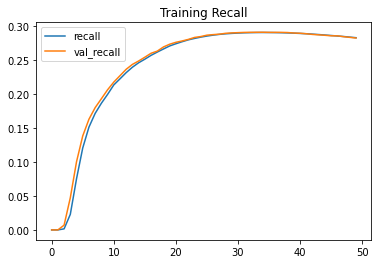

In [33]:
cfrnn.plot_training()

In [34]:
cfrnn_params['ckpt_dir']

'../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts'

In [35]:
test_set, left_out = leave_last_out(test_set_cfrnn, n_items=1)
ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out, batch_size=500, rank_at=rank_at, ckpt_dir=cfrnn_params['ckpt_dir'])
cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
cfrnn_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,4,0.004,0.004000,0.004000
1,5,19,0.019,0.003800,0.011119
2,10,43,0.043,0.004300,0.018755
3,15,71,0.071,0.004733,0.026086
4,20,92,0.092,0.004600,0.031059


In [36]:
cfrnn_metrics.to_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

---
# NCF

In [23]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0.000001,0.000001],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/GMF_weights_{file_name}/GMF_weights',
    'optimizer':'Adam'
}

MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],   #ML: [+-0.0005,0,0,0],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'weights_dir': f'../Logs/weights/MLP_weights_{file_name}/MLP_weights',
    'optimizer':'Adam'
}

NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0.000001,0.000001],
    'nolf': 8,
    'epochs': 25,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/NeuMF_weights_{file_name}/NeuMF_weights',
    'optimizer':'Adam'
}

In [24]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)
NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

In [21]:
sample_path = path + data_path + 'Samples/' + file_name + '_samples_4_neg/'
samples = NCF.load_samples(sample_path, file_name + '_sample', 25)

100% |########################################################################|


In [22]:
GMF_val_metrics = NCF.train_model('GMF', samples)


Fitting GMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
nolf                                                             8
regs                                                [1e-06, 1e-06]
epochs                                                          10
sample_size                                                 176012
num_neg                                                          4
weights_dir      ../Logs/weights/GMF_weights_am_like_ml/GMF_wei...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 880060 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


880060/880060 [==============================] - 15s 17us/sample - loss: 0.5449
Epoch: 1
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.3761
Epoch: 2
Train on 880060 samples
880060/880060 [==============================] - 15s 16us/sample - loss: 0.2331
Epoch: 3
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.1449
Epoch: 4
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.1038
Epoch: 5
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0825
Epoch: 6
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0696
Epoch: 7
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.0607
Epoch: 8
Train on 880060 samples
880060/880060 [==============================] - 14s 16us/sample - loss: 0.0541
Epoch: 9
Train o

In [25]:
MLP_val_metrics = NCF.train_model('MLP', samples)


Fitting MLP with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                            [1e-05, 1e-05, 1e-05, 1e-05]
epochs                                                          10
sample_size                                                 176012
num_neg                                                         10
weights_dir      ../Logs/weights/MLP_weights_am_like_ml/MLP_wei...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 880060 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


880060/880060 [==============================] - 17s 19us/sample - loss: 0.3631
Epoch: 1
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2922
Epoch: 2
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2802
Epoch: 3
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2617
Epoch: 4
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2223
Epoch: 5
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1792
Epoch: 6
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1460
Epoch: 7
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1222
Epoch: 8
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1055
Epoch: 9
Train o

In [26]:
NCF.use_pretrain_model()
NCF.NeuMF_params['optimizer'] = 'SGD'

In [ ]:
NeuMF_val_metrics = NCF.train_model('NeuMF', samples, train_set=train_set_mf, val_set=val_set_mf)

In [39]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,0,0.0000,0.00000,0.000000
1,5,1,0.0005,0.00010,0.000215
2,10,2,0.0010,0.00010,0.000360
3,15,3,0.0015,0.00010,0.000499
4,20,6,0.0030,0.00015,0.000843


In [28]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,9,0.009,0.009000,0.009000
1,5,19,0.019,0.003800,0.013959
2,10,24,0.024,0.002400,0.015539
3,15,32,0.032,0.002133,0.017668
4,20,38,0.038,0.001900,0.019069


In [29]:
neumf_metrics.to_pickle(path + 'Results/NCF/' + file_name + '_metrics')

---
## Compare

In [52]:
# file_name = 'ml_1m'
file_name = 'am_20k_users'
# file_name = 'am_like_ml'

In [53]:
bpr_metrics = pd.read_pickle(path + 'Results/BPR/' + file_name + '_metrics')
neumf_metrics = pd.read_pickle(path + 'Results/NCF/' + file_name + '_metrics')
cfrnn_metrics = pd.read_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

In [54]:
store_path = path + 'Plots/' + file_name
plot_title = f'Comparison {file_name}'

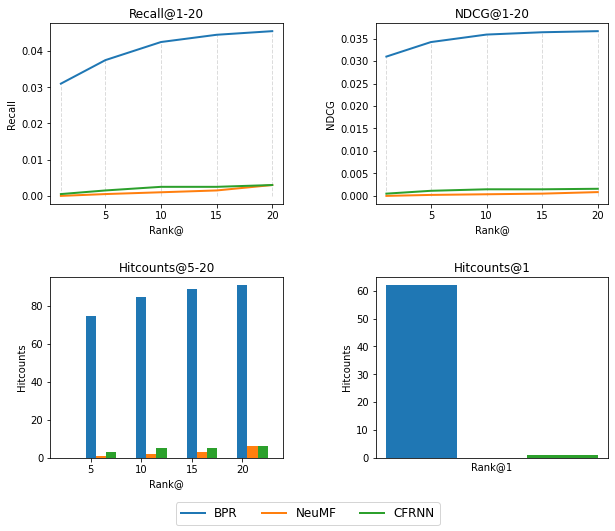

In [55]:
from visualize_results import plot_metrics
plot_metrics([bpr_metrics, neumf_metrics, cfrnn_metrics], ['BPR', 'NeuMF', 'CFRNN'], store_path=store_path)